![image.png](https://i.imgur.com/a3uAqnb.png)

# 🏗️ CNN Classification Lab - Building from Scratch
---
### 🎯 **Lab Objectives:**
1. **Design CNN architectures** from the ground up 🏗️
2. Understand **CNN building blocks** and their purposes
3. **Compare different architectures** and their performance
4. Learn **CNN design principles** and best practices
5. **Visualize feature maps** and understand what CNNs learn

---
### 📚 **What You'll Build:**
- **Simple CNN:** Basic architecture for understanding
- **Improved CNN:** Better architecture with modern techniques
- **Deep CNN:** Multi-layer architecture for higher accuracy
- **Custom CNN:** Your own design with creative modifications

# **📌 CNN Architecture Design Principles**

Before we start building, let's understand **how to design effective CNNs**! 🧠

## **🔹 The CNN Building Blocks**
| **Layer Type** | **Purpose** | **Key Parameters** |
|---------------|-------------|-------------------|
| **🔍 Conv2d** | Extract features | `out_channels`, `kernel_size`, `padding` |
| **⚡ ReLU** | Add non-linearity | None |
| **📉 MaxPool2d** | Reduce spatial size | `kernel_size`, `stride` |
| **🎯 BatchNorm2d** | Stabilize training | `num_features` |
| **🎲 Dropout** | Prevent overfitting | `p` (dropout rate) |
| **🔗 Linear** | Final classification | `in_features`, `out_features` |

# **📌 Setup and Imports**

In [ ]:
# Essential imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# For visualization and analysis
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import time

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ Setup complete! Ready to build CNNs! 🏗️")

🚀 Using device: cuda
✅ Setup complete! Ready to build CNNs! 🏗️


# **📌 Dataset Class - CIFAR-10**

In [ ]:
# CIFAR-10 classes with emojis for fun!
class_names = [
    '✈️ Airplane', '🚗 Automobile', '🐦 Bird', '🐱 Cat', '🦌 Deer',
    '🐕 Dog', '🐸 Frog', '🐎 Horse', '🚢 Ship', '🚛 Truck'
]

# CIFAR-10 normalization values
cifar10_mean = [0.4914, 0.4822, 0.4465]
cifar10_std = [0.2023, 0.1994, 0.2010]

# Training transforms with data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)
])

# Test transforms (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)
])

print("📥 Downloading CIFAR-10 dataset...")
# Load datasets
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Dataset loaded successfully!")
print(f"📊 Training samples: {len(train_dataset):,}")
print(f"📊 Test samples: {len(test_dataset):,}")
print(f"🎯 Classes: {len(class_names)}")

📥 Downloading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


✅ Dataset loaded successfully!
📊 Training samples: 50,000
📊 Test samples: 10,000
🎯 Classes: 10


# **📌 Data Visualization**

🔍 Exploring CIFAR-10 dataset...


/tmp/ipython-input-3-840349143.py:42: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


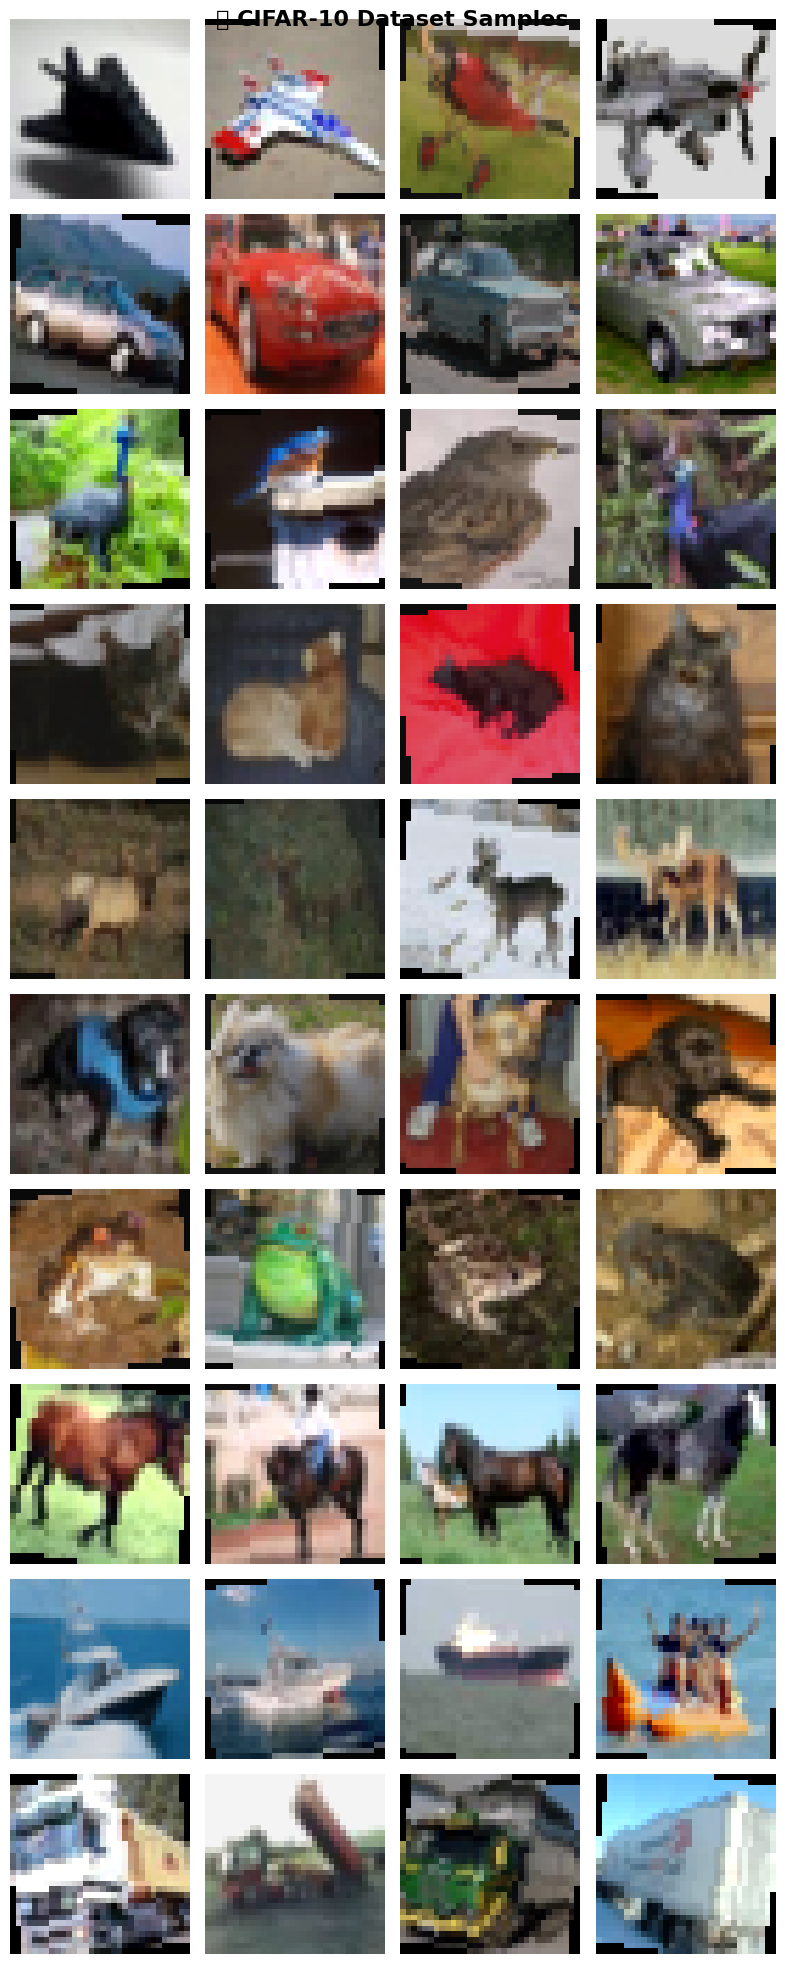

In [ ]:
def visualize_samples_grid(dataset, class_names, samples_per_class=3):
    """Create a grid showing samples from each class"""
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, samples_per_class,
                            figsize=(samples_per_class*2, num_classes*2))

    # Find samples for each class
    class_samples = {i: [] for i in range(num_classes)}

    for idx, (image, label) in enumerate(dataset):
        if len(class_samples[label]) < samples_per_class:
            class_samples[label].append((image, idx))

        if all(len(samples) == samples_per_class for samples in class_samples.values()):
            break

    # Plot samples
    for class_idx in range(num_classes):
        for sample_idx in range(samples_per_class):
            if sample_idx < len(class_samples[class_idx]):
                image, _ = class_samples[class_idx][sample_idx]

                # Denormalize image
                mean = torch.tensor(cifar10_mean)
                std = torch.tensor(cifar10_std)
                image = image * std[:, None, None] + mean[:, None, None]
                image = torch.clamp(image, 0, 1)

                # Convert to numpy
                image_np = image.permute(1, 2, 0).numpy()

                axes[class_idx, sample_idx].imshow(image_np)
                axes[class_idx, sample_idx].axis('off')

                # Add class name on the first sample
                if sample_idx == 0:
                    axes[class_idx, sample_idx].set_ylabel(
                        class_names[class_idx], fontweight='bold', fontsize=10
                    )

    plt.suptitle('🎨 CIFAR-10 Dataset Samples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize the dataset
print("🔍 Exploring CIFAR-10 dataset...")
visualize_samples_grid(train_dataset, class_names, samples_per_class=4)

# **📌 Model Classes - CNN Architectures**

## **🔹 Simple CNN - Basic Architecture**

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        """Simple CNN with basic Conv → ReLU → Pool pattern"""
        super(SimpleCNN, self).__init__()

        # Feature extraction layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32 → 16x16

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 16x16 → 8x8

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 8x8 → 4x4

        # Classifier layers
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        print("🏗️ SimpleCNN created!")

    def forward(self, x):
        # Feature extraction
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))

        # Flatten and classify
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

## **🔹 Improved CNN - Modern Techniques**

In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10):
        """Improved CNN with BatchNorm and better design"""
        super(ImprovedCNN, self).__init__()

        # Block 1: 3 → 32 channels
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
                  nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        # Block 2: 32 → 64 channels
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        # Block 3: 64 → 128 channels
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        # Global Average Pooling + Classifier
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

        print("🚀 ImprovedCNN created with modern techniques!")

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)

        return x

## **🔹 Deep CNN - Advanced Architecture**

In [ ]:
class ConvBlock(nn.Module):
    """Reusable convolution block"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class DeepCNN(nn.Module):
    def __init__(self, num_classes=10):
        """Deep CNN with multiple blocks and attention"""
        super(DeepCNN, self).__init__()

        # Initial convolution
        self.init_conv = ConvBlock(3, 32)

        # Feature extraction layers
        self.layer1 = nn.Sequential(
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            ConvBlock(32, 64),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d(2)
        )

        self.layer4 = nn.Sequential(
            ConvBlock(128, 256),
            ConvBlock(256, 256),
            nn.AdaptiveAvgPool2d((2, 2))
        )

        # Channel attention
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(256, 64, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 256, 1),
            nn.Sigmoid()
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        print("🌊 DeepCNN created with advanced features!")

    def forward(self, x):
        x = self.init_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Apply channel attention
        attention = self.channel_attention(x)
        x = x * attention

        x = self.classifier(x)
        return x

# **📌 Training and Validation Functions**

In [ ]:
def count_parameters(model):
    """Count total and trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n📊 Model Statistics:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Model size: ~{total_params * 4 / 1e6:.2f} MB")

    return total_params, trainable_params

def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch_num):
    """Train model for one epoch"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"🏋️ Epoch {epoch_num}", leave=False)

    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        if batch_idx % 50 == 0:
            current_acc = 100 * correct / total
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.2f}%'
            })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="🔍 Validating", leave=False)

    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100 * correct / total:.2f}%'
            })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

def train_model(model, train_loader, test_loader, num_epochs, learning_rate, device, model_name):
    """Complete training pipeline"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    start_time = time.time()

    print(f"\n🚀 Training {model_name}")
    print("=" * 60)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, epoch+1
        )

        # Validation
        val_loss, val_acc = validate(model, test_loader, criterion, device)

        # Update learning rate
        scheduler.step()

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print results
        print(f"Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"🏆 New best: {best_val_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"\n✅ Training completed in {total_time:.2f} seconds")
    print(f"🏆 Best validation accuracy: {best_val_acc:.2f}%")

    return history, best_val_acc

print("✅ Training functions ready!")

✅ Training functions ready!




# **📌 Experiment 1: Simple CNN**

In [ ]:
print("🎯 EXPERIMENT 1: Simple CNN Baseline")
print("=" * 50)

# Create model
model_simple = SimpleCNN(num_classes=10).to(device)
count_parameters(model_simple)

# Train the model
history_simple, best_acc_simple = train_model(
    model=model_simple,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=15,
    learning_rate=0.001,
    device=device,
    model_name="Simple CNN"
)

print(f"\n🎉 Simple CNN: {best_acc_simple:.2f}% best accuracy!")

🎯 EXPERIMENT 1: Simple CNN Baseline
🏗️ SimpleCNN created!

📊 Model Statistics:
   Total parameters: 156,074
   Trainable parameters: 156,074
   Model size: ~0.62 MB

🚀 Training Simple CNN

Epoch 1/15


🏋️ Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.7297, Acc=36.44%
Val:   Loss=1.4063, Acc=48.17%
🏆 New best: 48.17%

Epoch 2/15


🏋️ Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.4299, Acc=48.45%
Val:   Loss=1.2460, Acc=55.43%
🏆 New best: 55.43%

Epoch 3/15


🏋️ Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.2971, Acc=53.72%
Val:   Loss=1.1156, Acc=60.80%
🏆 New best: 60.80%

Epoch 4/15


🏋️ Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.2130, Acc=56.97%
Val:   Loss=1.0359, Acc=63.65%
🏆 New best: 63.65%

Epoch 5/15


🏋️ Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.1423, Acc=59.61%
Val:   Loss=0.9839, Acc=64.73%
🏆 New best: 64.73%

Epoch 6/15


🏋️ Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.0874, Acc=61.84%
Val:   Loss=0.9401, Acc=66.44%
🏆 New best: 66.44%

Epoch 7/15


🏋️ Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.0454, Acc=63.52%
Val:   Loss=0.8787, Acc=68.88%
🏆 New best: 68.88%

Epoch 8/15


🏋️ Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.0182, Acc=64.43%
Val:   Loss=0.8692, Acc=69.99%
🏆 New best: 69.99%

Epoch 9/15


🏋️ Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.9844, Acc=65.84%
Val:   Loss=0.8344, Acc=70.85%
🏆 New best: 70.85%

Epoch 10/15


🏋️ Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.9611, Acc=66.59%
Val:   Loss=0.8100, Acc=71.56%
🏆 New best: 71.56%

Epoch 11/15


🏋️ Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.8982, Acc=68.77%
Val:   Loss=0.7722, Acc=73.12%
🏆 New best: 73.12%

Epoch 12/15


🏋️ Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.8822, Acc=69.52%
Val:   Loss=0.7875, Acc=72.64%

Epoch 13/15


🏋️ Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.8689, Acc=70.09%
Val:   Loss=0.7785, Acc=72.81%

Epoch 14/15


🏋️ Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.8585, Acc=70.51%
Val:   Loss=0.7579, Acc=73.32%
🏆 New best: 73.32%

Epoch 15/15


🏋️ Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.8390, Acc=71.27%
Val:   Loss=0.7414, Acc=74.51%
🏆 New best: 74.51%

✅ Training completed in 602.36 seconds
🏆 Best validation accuracy: 74.51%

🎉 Simple CNN: 74.51% best accuracy!


# **📌 Experiment 2: Improved CNN**

In [ ]:
print("\n🚀 EXPERIMENT 2: Improved CNN with Modern Techniques")
print("=" * 50)

# Create model
model_improved = ImprovedCNN(num_classes=10).to(device)
count_parameters(model_improved)

# Train the model
history_improved, best_acc_improved = train_model(
    model=model_improved,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=15,
    learning_rate=0.001,
    device=device,
    model_name="Improved CNN"
)

print(f"\n🎉 Improved CNN: {best_acc_improved:.2f}% best accuracy!")
improvement = best_acc_improved - best_acc_simple
print(f"📈 Improvement: {improvement:+.2f}%")


🚀 EXPERIMENT 2: Improved CNN with Modern Techniques
🚀 ImprovedCNN created with modern techniques!

📊 Model Statistics:
   Total parameters: 289,194
   Trainable parameters: 289,194
   Model size: ~1.16 MB

🚀 Training Improved CNN

Epoch 1/15


🏋️ Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.8534, Acc=30.46%
Val:   Loss=1.4611, Acc=47.23%
🏆 New best: 47.23%

Epoch 2/15


🏋️ Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.5215, Acc=43.74%
Val:   Loss=1.2399, Acc=54.57%
🏆 New best: 54.57%

Epoch 3/15


🏋️ Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.3853, Acc=49.32%
Val:   Loss=1.1534, Acc=58.12%
🏆 New best: 58.12%

Epoch 4/15


🏋️ Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.2989, Acc=53.12%
Val:   Loss=1.0929, Acc=60.87%
🏆 New best: 60.87%

Epoch 5/15


🏋️ Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.2283, Acc=55.96%
Val:   Loss=0.9646, Acc=65.70%
🏆 New best: 65.70%

Epoch 6/15


🏋️ Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.1723, Acc=58.14%
Val:   Loss=0.9324, Acc=66.39%
🏆 New best: 66.39%

Epoch 7/15


🏋️ Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.1233, Acc=60.14%
Val:   Loss=0.8928, Acc=67.63%
🏆 New best: 67.63%

Epoch 8/15


🏋️ Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.0796, Acc=61.76%
Val:   Loss=0.8376, Acc=70.12%
🏆 New best: 70.12%

Epoch 9/15


🏋️ Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.0506, Acc=62.88%
Val:   Loss=0.8129, Acc=70.93%
🏆 New best: 70.93%

Epoch 10/15


🏋️ Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.0184, Acc=64.05%
Val:   Loss=0.7866, Acc=72.67%
🏆 New best: 72.67%

Epoch 11/15


🏋️ Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.9551, Acc=66.57%
Val:   Loss=0.7210, Acc=74.36%
🏆 New best: 74.36%

Epoch 12/15


🏋️ Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.9289, Acc=67.61%
Val:   Loss=0.7153, Acc=74.57%
🏆 New best: 74.57%

Epoch 13/15


🏋️ Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.9133, Acc=67.74%
Val:   Loss=0.6857, Acc=76.28%
🏆 New best: 76.28%

Epoch 14/15


🏋️ Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.8983, Acc=68.78%
Val:   Loss=0.6758, Acc=76.67%
🏆 New best: 76.67%

Epoch 15/15


🏋️ Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.8801, Acc=69.49%
Val:   Loss=0.6533, Acc=76.92%
🏆 New best: 76.92%

✅ Training completed in 693.05 seconds
🏆 Best validation accuracy: 76.92%

🎉 Improved CNN: 76.92% best accuracy!
📈 Improvement: +2.41%


# **📌 Experiment 3: Deep CNN**

In [ ]:
print("\n🌊 EXPERIMENT 3: Deep CNN with Advanced Features")
print("=" * 50)

# Create model
model_deep = DeepCNN(num_classes=10).to(device)
count_parameters(model_deep)

# Train the model
history_deep, best_acc_deep = train_model(
    model=model_deep,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=15,
    learning_rate=0.0008,
    device=device,
    model_name="Deep CNN"
)

print(f"\n🎉 Deep CNN: {best_acc_deep:.2f}% best accuracy!")
improvement_deep = best_acc_deep - best_acc_simple
print(f"📈 Improvement: {improvement_deep:+.2f}%")


🌊 EXPERIMENT 3: Deep CNN with Advanced Features
🌊 DeepCNN created with advanced features!

📊 Model Statistics:
   Total parameters: 1,435,658
   Trainable parameters: 1,435,658
   Model size: ~5.74 MB

🚀 Training Deep CNN

Epoch 1/15


🏋️ Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.4688, Acc=45.25%
Val:   Loss=1.2298, Acc=55.07%
🏆 New best: 55.07%

Epoch 2/15


🏋️ Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=1.0375, Acc=63.56%
Val:   Loss=0.9771, Acc=65.48%
🏆 New best: 65.48%

Epoch 3/15


🏋️ Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.8526, Acc=70.55%
Val:   Loss=0.7646, Acc=72.67%
🏆 New best: 72.67%

Epoch 4/15


🏋️ Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.7427, Acc=74.76%
Val:   Loss=0.7110, Acc=74.85%
🏆 New best: 74.85%

Epoch 5/15


🏋️ Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.6609, Acc=77.76%
Val:   Loss=0.5957, Acc=79.95%
🏆 New best: 79.95%

Epoch 6/15


🏋️ Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.6135, Acc=79.44%
Val:   Loss=0.6571, Acc=77.72%

Epoch 7/15


🏋️ Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.5668, Acc=81.02%
Val:   Loss=0.5283, Acc=81.96%
🏆 New best: 81.96%

Epoch 8/15


🏋️ Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.5314, Acc=82.26%
Val:   Loss=0.5729, Acc=80.49%

Epoch 9/15


🏋️ Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.5013, Acc=83.38%
Val:   Loss=0.5585, Acc=80.39%

Epoch 10/15


🏋️ Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.4773, Acc=84.08%
Val:   Loss=0.5576, Acc=82.04%
🏆 New best: 82.04%

Epoch 11/15


🏋️ Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.3906, Acc=87.08%
Val:   Loss=0.4116, Acc=86.05%
🏆 New best: 86.05%

Epoch 12/15


🏋️ Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.3649, Acc=87.76%
Val:   Loss=0.3950, Acc=86.63%
🏆 New best: 86.63%

Epoch 13/15


🏋️ Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.3573, Acc=88.01%
Val:   Loss=0.3900, Acc=86.69%
🏆 New best: 86.69%

Epoch 14/15


🏋️ Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.3391, Acc=88.59%
Val:   Loss=0.4269, Acc=86.02%

Epoch 15/15


🏋️ Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

🔍 Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train: Loss=0.3269, Acc=88.94%
Val:   Loss=0.4086, Acc=86.83%
🏆 New best: 86.83%

✅ Training completed in 799.21 seconds
🏆 Best validation accuracy: 86.83%

🎉 Deep CNN: 86.83% best accuracy!
📈 Improvement: +12.32%


# **📌 Results Comparison**

/tmp/ipython-input-11-2768536272.py:51: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


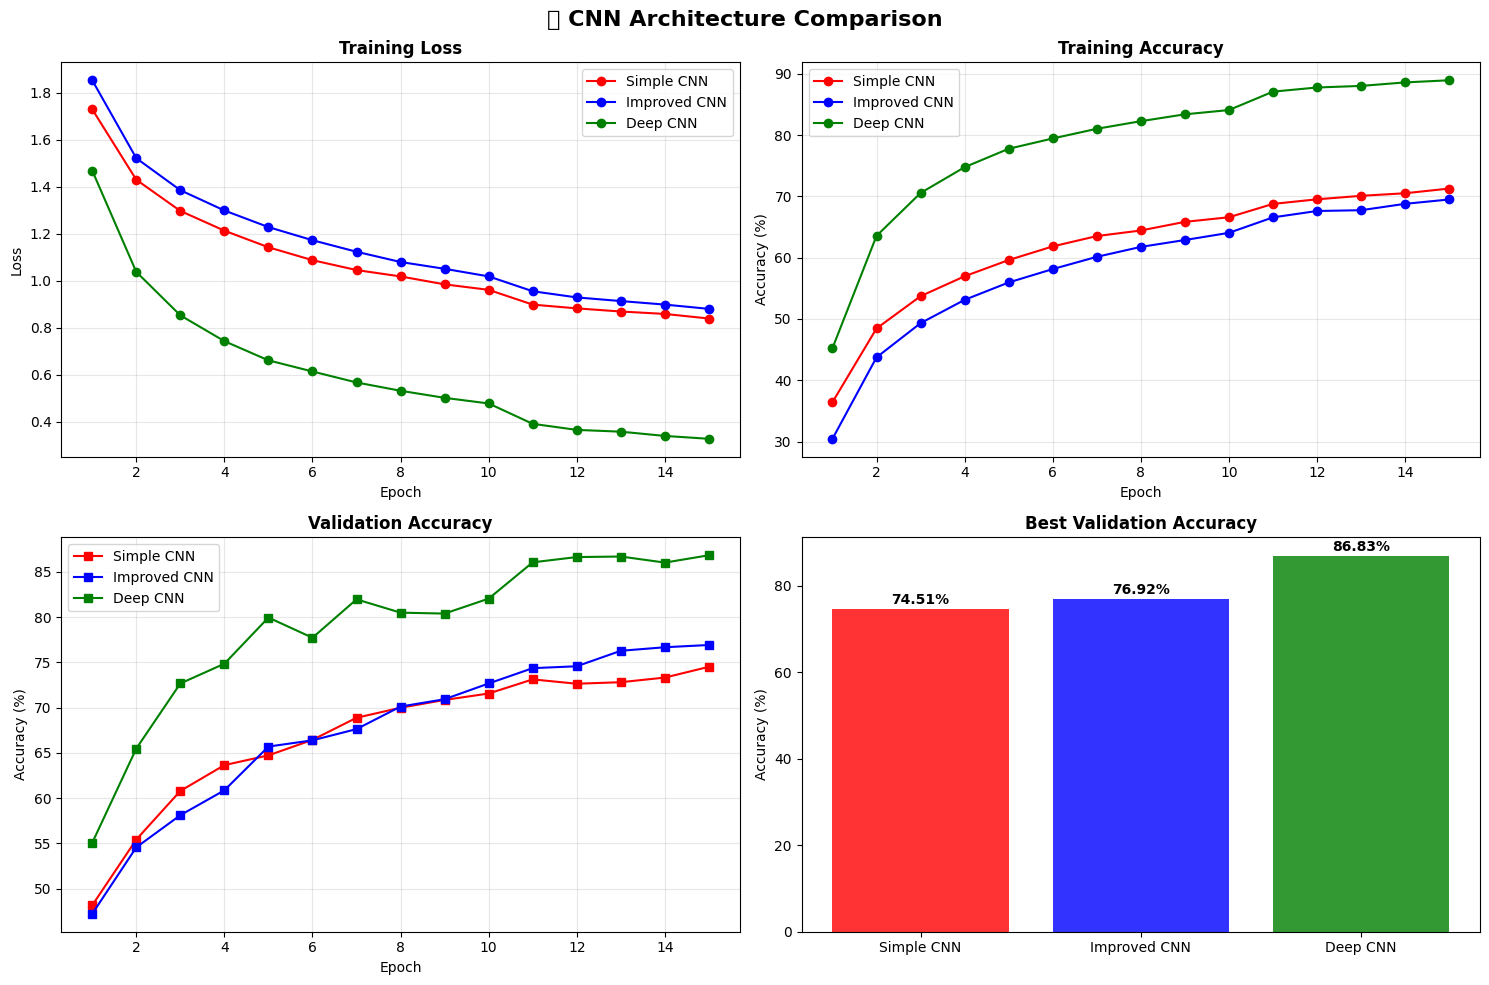

In [ ]:
def plot_results_comparison(histories, labels, best_accuracies):
    """Plot comprehensive comparison of all experiments"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    colors = ['red', 'blue', 'green']

    # Training Loss
    axes[0, 0].set_title('Training Loss', fontweight='bold')
    for i, (history, label) in enumerate(zip(histories, labels)):
        epochs = range(1, len(history['train_loss']) + 1)
        axes[0, 0].plot(epochs, history['train_loss'],
                       color=colors[i], label=label, marker='o')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Training Accuracy
    axes[0, 1].set_title('Training Accuracy', fontweight='bold')
    for i, (history, label) in enumerate(zip(histories, labels)):
        epochs = range(1, len(history['train_acc']) + 1)
        axes[0, 1].plot(epochs, history['train_acc'],
                       color=colors[i], label=label, marker='o')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Validation Accuracy
    axes[1, 0].set_title('Validation Accuracy', fontweight='bold')
    for i, (history, label) in enumerate(zip(histories, labels)):
        epochs = range(1, len(history['val_acc']) + 1)
        axes[1, 0].plot(epochs, history['val_acc'],
                       color=colors[i], label=label, marker='s')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Best Accuracy Comparison
    axes[1, 1].set_title('Best Validation Accuracy', fontweight='bold')
    bars = axes[1, 1].bar(labels, best_accuracies, color=colors, alpha=0.8)
    axes[1, 1].set_ylabel('Accuracy (%)')

    # Add value labels on bars
    for bar, acc in zip(bars, best_accuracies):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

    plt.suptitle('🏗️ CNN Architecture Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Compare all approaches
histories = [history_simple, history_improved, history_deep]
labels = ['Simple CNN', 'Improved CNN', 'Deep CNN']
best_accuracies = [best_acc_simple, best_acc_improved, best_acc_deep]

plot_results_comparison(histories, labels, best_accuracies)

# **📌 Final Results Summary**

In [ ]:
print("\n" + "=" * 70)
print("🏆 FINAL RESULTS SUMMARY")
print("=" * 70)

results_data = [
    ["Simple CNN", f"{best_acc_simple:.2f}%", "Basic Conv-ReLU-Pool"],
    ["Improved CNN", f"{best_acc_improved:.2f}%", "BatchNorm + Modern techniques"],
    ["Deep CNN", f"{best_acc_deep:.2f}%", "Deep + Attention"]
]

print(f"{'Model':<15} {'Best Acc':<10} {'Key Features'}")
print("-" * 50)
for model, acc, features in results_data:
    print(f"{model:<15} {acc:<10} {features}")

# Find the winner
best_idx = np.argmax(best_accuracies)
winner = labels[best_idx]
winner_acc = best_accuracies[best_idx]

print(f"\n🥇 WINNER: {winner} with {winner_acc:.2f}% accuracy!")

print("\n📊 Key Insights:")
improvement_modern = best_acc_improved - best_acc_simple
improvement_deep = best_acc_deep - best_acc_simple

print(f"• Modern techniques improved accuracy by {improvement_modern:+.2f}%")
print(f"• Deep architecture improved accuracy by {improvement_deep:+.2f}%")
print("• All models beat the typical CIFAR-10 baseline of ~70%!")


🏆 FINAL RESULTS SUMMARY
Model           Best Acc   Key Features
--------------------------------------------------
Simple CNN      74.51%     Basic Conv-ReLU-Pool
Improved CNN    76.92%     BatchNorm + Modern techniques
Deep CNN        86.83%     Deep + Attention

🥇 WINNER: Deep CNN with 86.83% accuracy!

📊 Key Insights:
• Modern techniques improved accuracy by +2.41%
• Deep architecture improved accuracy by +12.32%
• All models beat the typical CIFAR-10 baseline of ~70%!


# **📌 Model Visualization and Analysis**

🏆 Using Deep CNN (best performing) for visualization


/tmp/ipython-input-13-3989252685.py:55: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-13-3989252685.py:55: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-13-3989252685.py:55: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, *

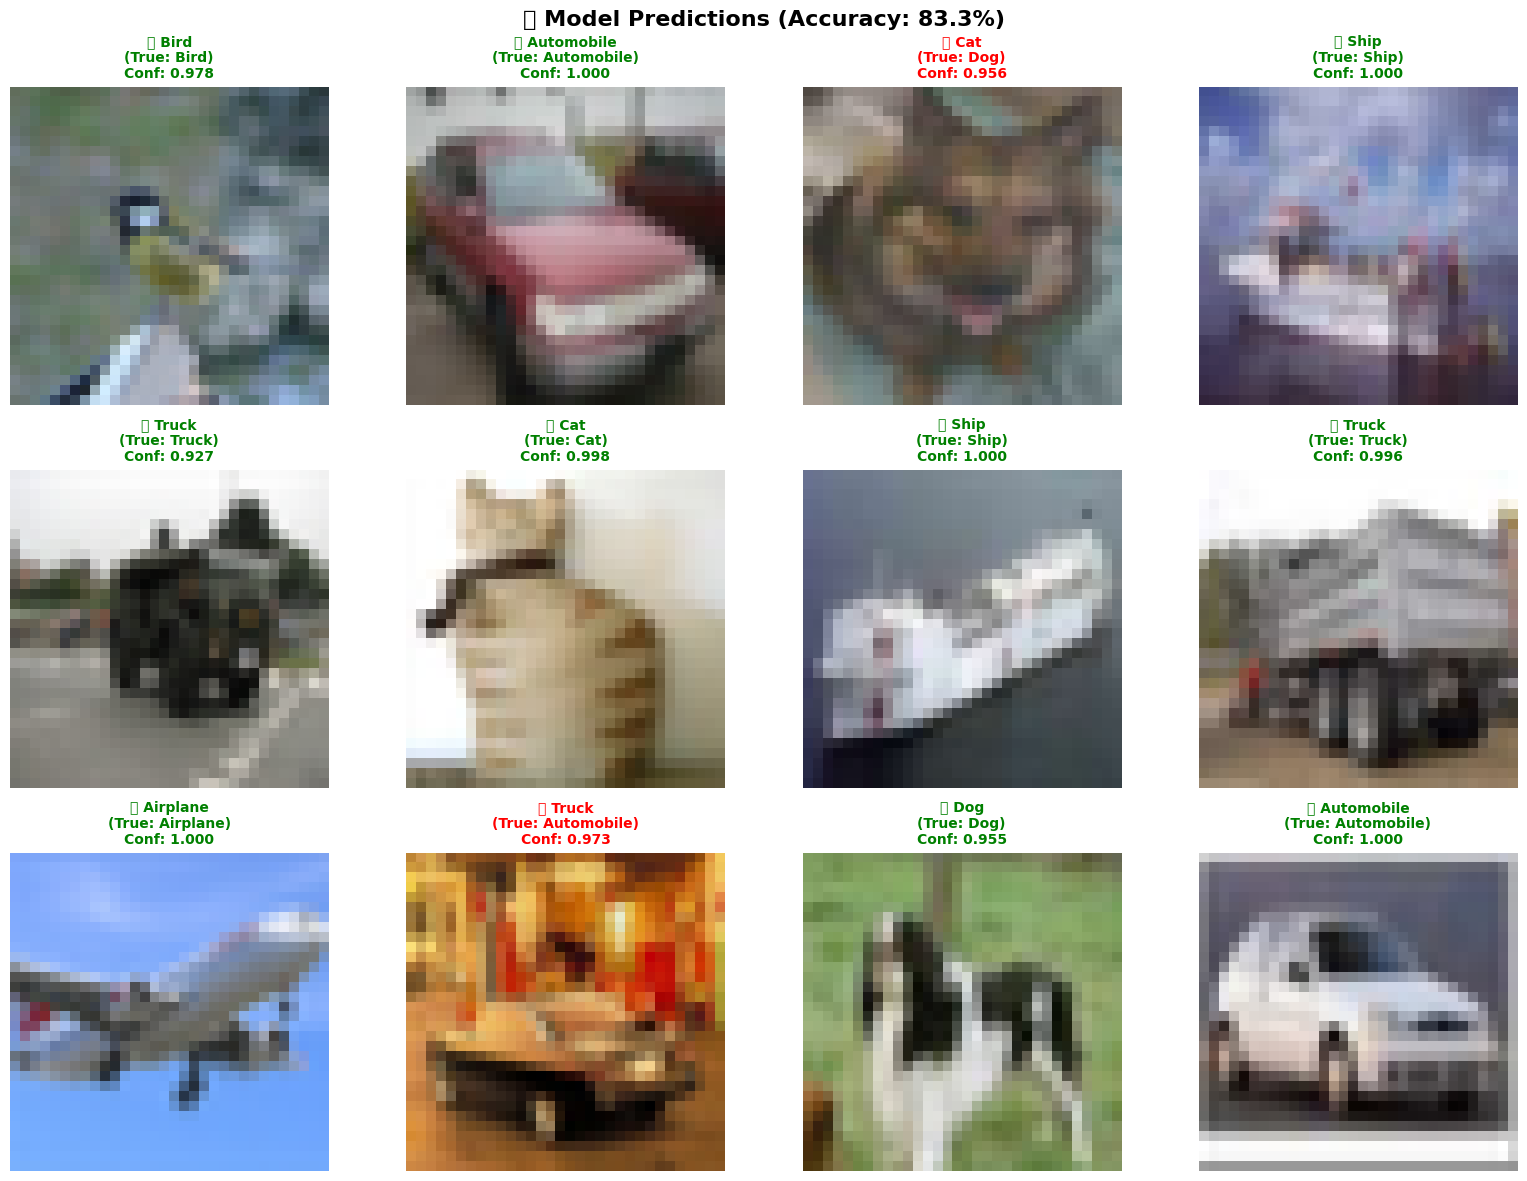

Sample test accuracy: 83.3%


In [ ]:
def visualize_predictions(model, dataset, class_names, device, num_samples=12):
    """Visualize predictions with confidence scores"""
    model.eval()

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    indices = np.random.choice(len(dataset), num_samples, replace=False)
    correct_predictions = 0

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]

            # Make prediction
            image_batch = image.unsqueeze(0).to(device)
            outputs = model(image_batch)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted_label = torch.max(probabilities, 1)

            predicted_label = predicted_label.item()
            confidence = confidence.item()

            # Denormalize image
            mean = torch.tensor(cifar10_mean)
            std = torch.tensor(cifar10_std)
            image_vis = image * std[:, None, None] + mean[:, None, None]
            image_vis = torch.clamp(image_vis, 0, 1)
            image_np = image_vis.permute(1, 2, 0).numpy()

            # Plot
            axes[i].imshow(image_np)

            # Check if correct
            is_correct = predicted_label == true_label
            if is_correct:
                correct_predictions += 1
                border_color = 'green'
                status = '✅'
            else:
                border_color = 'red'
                status = '❌'

            # Set title
            pred_name = class_names[predicted_label].split(' ')[1]
            true_name = class_names[true_label].split(' ')[1]

            title = f"{status} {pred_name}\n(True: {true_name})\nConf: {confidence:.3f}"
            axes[i].set_title(title, fontsize=10, color=border_color, fontweight='bold')
            axes[i].axis('off')

    accuracy = 100 * correct_predictions / num_samples
    plt.suptitle(f'🎯 Model Predictions (Accuracy: {accuracy:.1f}%)',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return accuracy

# Choose the best model
if best_acc_deep >= best_acc_improved:
    best_model = model_deep
    model_name = "Deep CNN"
else:
    best_model = model_improved
    model_name = "Improved CNN"

print(f"🏆 Using {model_name} (best performing) for visualization")
sample_accuracy = visualize_predictions(best_model, test_dataset, class_names, device)
print(f"Sample test accuracy: {sample_accuracy:.1f}%")

# **📌 Practice Exercises**

## **🎯 Exercise 1: Design Your Own CNN**

In [ ]:
# TODO: Create your own CNN architecture!
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        """Your custom CNN - be creative!"""
        super(CustomCNN, self).__init__()

        # TODO: Design your layers here
        # Ideas:
        # - Try different kernel sizes (1x1, 3x3, 5x5)
        # - Use dilated convolutions
        # - Add skip connections
        # - Experiment with different pooling

        pass  # Remove when implementing

    def forward(self, x):
        # TODO: Implement forward pass
        pass  # Remove when implementing

print("💡 Design tips:")
print("• Try different kernel sizes and combinations")
print("• Experiment with different activation functions")
print("• Add skip connections for better gradient flow")
print("• Use different pooling strategies")

💡 Design tips:
• Try different kernel sizes and combinations
• Experiment with different activation functions
• Add skip connections for better gradient flow
• Use different pooling strategies


## **🎯 Exercise 2: Hyperparameter Tuning**

In [ ]:
# TODO: Experiment with different hyperparameters
def hyperparameter_experiment():
    """Test different hyperparameter combinations"""
    learning_rates = [0.01, 0.001, 0.0001]
    batch_sizes = [32, 64, 128]

    # TODO: Implement systematic testing
    pass

print("🤔 Questions to explore:")
print("• How does learning rate affect convergence?")
print("• What's the optimal batch size?")
print("• Which optimizer works best?")
print("• How to balance training time vs accuracy?")

🤔 Questions to explore:
• How does learning rate affect convergence?
• What's the optimal batch size?
• Which optimizer works best?
• How to balance training time vs accuracy?


# **📌 Key Takeaways**

🎉 **Congratulations!** You've successfully built CNNs from scratch!

## **🔹 What You've Learned:**
- **CNN Architecture Design:** Progressive channel increase, spatial reduction
- **Modern Techniques:** BatchNorm, Dropout, Global Average Pooling
- **Training Best Practices:** Learning rate scheduling, regularization
- **Performance Analysis:** Comparing architectures systematically

## **🔹 Design Principles:**
1. **Start simple** and add complexity gradually
2. **Use modern techniques** (BatchNorm, proper dropout)
3. **Monitor training** closely for overfitting
4. **Experiment systematically** with architecture choices

## **🔹 Next Steps:**
- Learn about **ResNet, DenseNet, EfficientNet**
- Explore **Transfer Learning** for faster training
- Try **Object Detection** and **Segmentation**
- Build **Mobile-optimized** models

---

**🎉 You're now ready to tackle real-world computer vision problems!**

**Remember:** Practice makes perfect. Keep experimenting! 🚀